In [1]:
# kaggle house price prediction
%matplotlib inline
import pandas as pd
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
train_data = pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('../data/house-prices-advanced-regression-techniques/test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [3]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [4]:
# id is useless, so we delete it from the dataset
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[1:-1]))

In [5]:
# standardization dataset
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index  # get the indices of numeric data from dataset
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# after standardization, as the average value was subtracted in the process, we could simply set the NaN num as 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [6]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2917, 332)

In [7]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32
)

In [9]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

# use the linear model as the baseline
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [10]:
def log_rmse(net, features, labels):
    # use the log to reduce the effects caused by different prices to the evaluation of the model
    clipped_preds = torch.clamp(net(features), 1, float('inf'))  # set the output of the net into range 1 ~ inf
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [11]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [12]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx, :]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [13]:
def k_fold(k, X_train, y_train, num_epochs, lr, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, lr, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse',
                     xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, training log rmse {float(train_ls[-1]):f}, '
              f'validation log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, training log rmse 0.169889, validation log rmse 0.156756
fold 2, training log rmse 0.162388, validation log rmse 0.190664
fold 3, training log rmse 0.164287, validation log rmse 0.168406
fold 4, training log rmse 0.168185, validation log rmse 0.154567
fold 5, training log rmse 0.163397, validation log rmse 0.183130
5-fold validation: average training log rmse: 0.165629,average validation log rmse: 0.17070452272891998:f


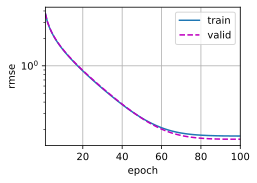

In [14]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: average training log rmse: {float(train_l):f},'
      f'average validation log rmse: {float(valid_l)}:f')

training log rmse: 0.162633


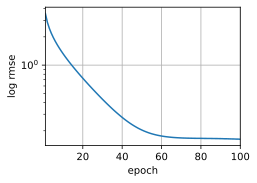

In [18]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls],
             xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'training log rmse: {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)